<a href="https://colab.research.google.com/github/SachinLamichhane/Google-Colabs/blob/main/FullandFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
import shutil
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt


In [127]:
#from google.colab import drive
#drive.mount('/content/drive')

## Data loaded locally

In [152]:

#data_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database'
data_dir = '../dataset'



 ## Create directories for training and validation data**

In [156]:
#train_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database_train'
#validation_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database_validation'

train_dir = '../dataset/TB_Chest_Radiography_Database_train'
validation_dir = '../dataset/TB_Chest_Radiography_Database_validation'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

##  Create class subdirectories in training and validation directories

In [159]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Create class subdirectories in training and validation directories
class_names = ['Tuberculosis', 'Normal']  # Adjust class names accordingly
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

In [161]:
class_names = ['Tuberculosis', 'Normal']
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

# Load image paths and labels
image_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)


## Convert labels to numeric format


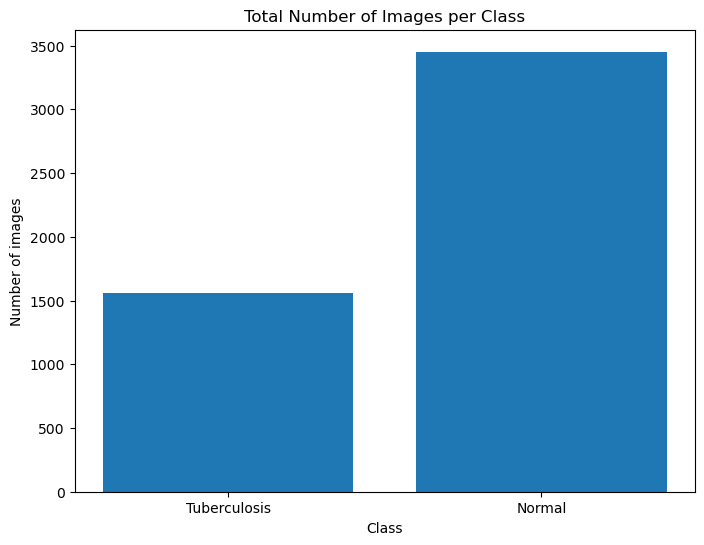

In [163]:
# Convert labels to numeric format
label_dict = {class_name: idx for idx, class_name in enumerate(class_names)}
labels = np.array([label_dict[label] for label in labels])

# Plot total number of images per class
def plot_distribution(data, title):
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, [np.sum(data == label_dict[class_name]) for class_name in class_names])
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.show()

# Plot initial distribution of images
plot_distribution(labels, 'Total Number of Images per Class')

## Split data into training and validation sets

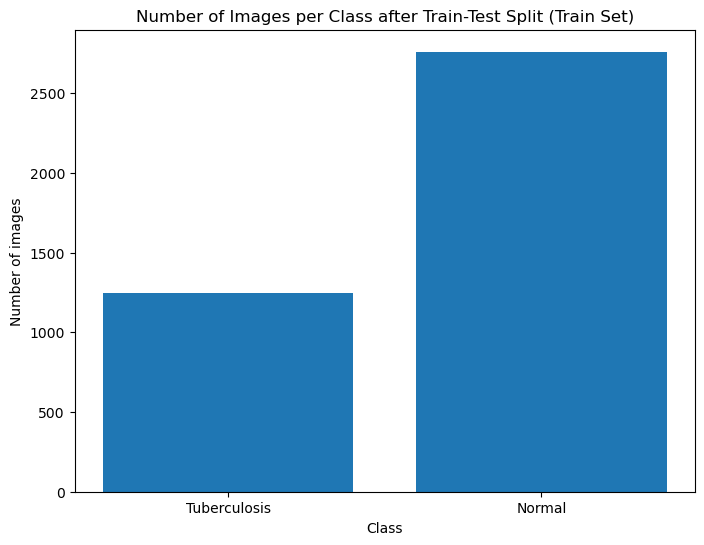

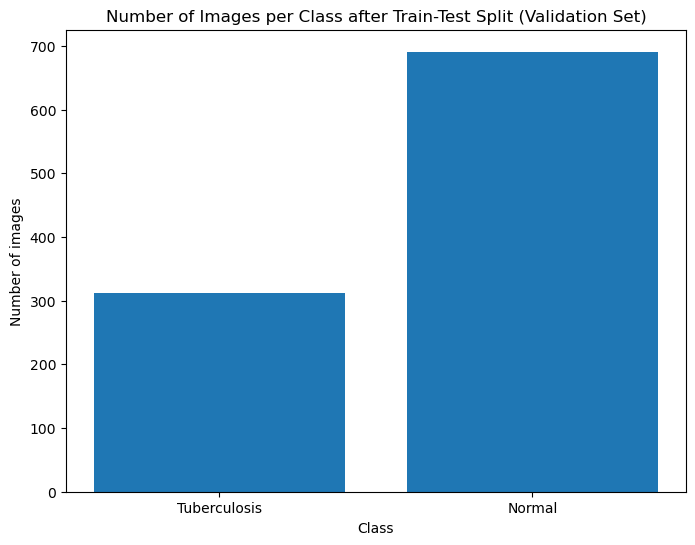

In [165]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Plot distribution of images after train-test split
plot_distribution(train_labels, 'Number of Images per Class after Train-Test Split (Train Set)')
plot_distribution(val_labels, 'Number of Images per Class after Train-Test Split (Validation Set)')


# Apply random undersampling to balance the classes in the training set

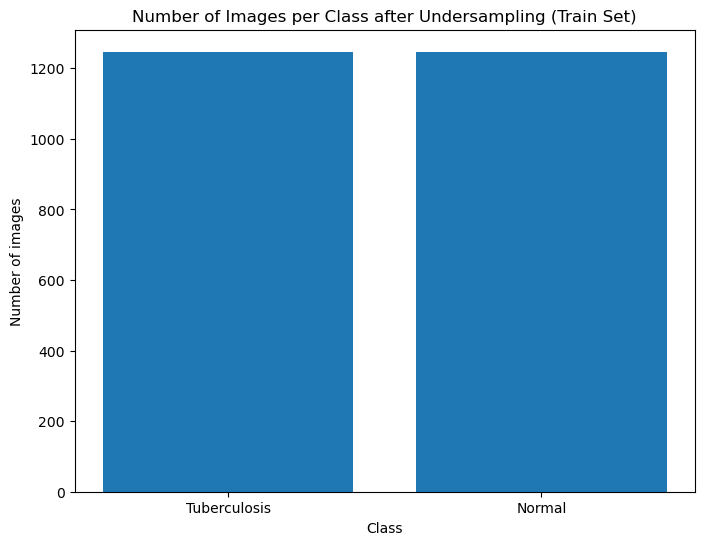

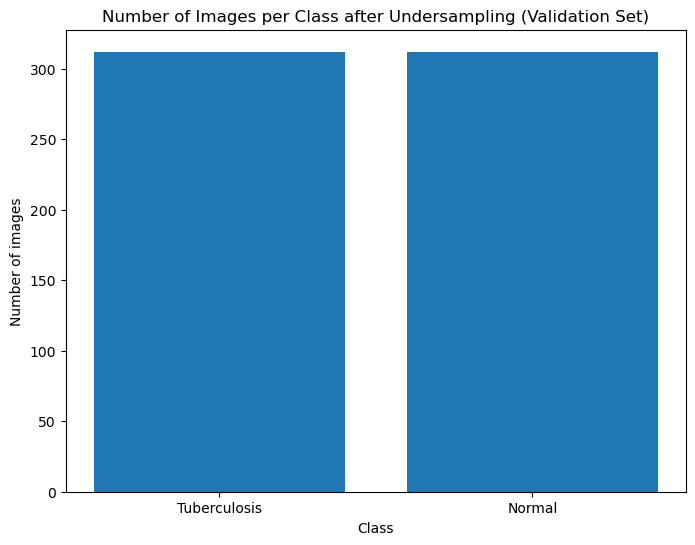

In [167]:
# Plot distribution of images after undersampling
rus = RandomUnderSampler()
train_paths, train_labels = rus.fit_resample(np.array(train_paths).reshape(-1, 1), train_labels)
train_paths = train_paths.flatten()
plot_distribution(train_labels, 'Number of Images per Class after Undersampling (Train Set)')
# Apply random undersampling to balance the classes in the validation set
val_paths, val_labels = rus.fit_resample(np.array(val_paths).reshape(-1, 1), val_labels)
val_paths = val_paths.flatten()
plot_distribution(val_labels, 'Number of Images per Class after Undersampling (Validation Set)')




## copy images for training and validation


In [169]:
import os
import shutil

def copy_images(image_paths, labels, target_dir):
    count = {class_name: 0 for class_name in class_names}
    for img_path, label in zip(image_paths, labels):
        class_name = class_names[label]
        target_class_dir = os.path.join(target_dir, class_name)
        if not os.path.exists(target_class_dir):
            os.makedirs(target_class_dir)
        
        # Ensure the source path is a file before attempting to copy
        if os.path.isfile(img_path):
            shutil.copy(img_path, target_class_dir)
            count[class_name] += 1
        else:
            print(f"Skipping directory: {img_path}")
    return count

train_count = copy_images(train_paths, train_labels, train_dir)
val_count = copy_images(val_paths, val_labels, validation_dir)

print("Number of images copied for training after undersampling:")
print(train_count)

print("Number of images copied for validation after undersampling:")
print(val_count)


Skipping directory: ../dataset/Tuberculosis/.ipynb_checkpoints
Number of images copied for training after undersampling:
{'Tuberculosis': 1246, 'Normal': 1247}
Number of images copied for validation after undersampling:
{'Tuberculosis': 312, 'Normal': 312}


## transfer learning with DenseNet121

In [171]:
base_model = DenseNet121(weights='imagenet', include_top=False, classes=2, input_shape=(300, 300, 3))

# Add custom layers on top of the base model for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification (1 output unit with sigmoid activation)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])




## # Prepare data generators for training and validation datasets


In [175]:
train_datagen = ImageDataGenerator(rescale=1./255,  # Normalize pixel values to [0, 1]
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize pixel values to [0, 1]

train_generator = train_datagen.flow_from_directory(
    train_dir,  # Directory containing the training data
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle = False)  # Binary classification

validation_generator = test_datagen.flow_from_directory(
    validation_dir,  # Directory containing the validation data
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle = False)  # Binary classification

Found 2493 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## training by unfreezing and fine tuning last five layers of densenet121

In [239]:

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-5:]:  # Unfreeze the last 5 layers for fine-tuning
    layer.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model for fine-tuning
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10)  # Adjust the number of epochs as needed




Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 396s 5s/step - accuracy: 0.4083 - loss: 1.5571 - val_accuracy: 0.9103 - val_loss: 0.2385
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 404s 5s/step - accuracy: 0.4625 - loss: 1.0661 - val_accuracy: 0.9006 - val_loss: 0.2601
Epoch 3/10


2024-07-24 14:27:33.574315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:189: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-24 14:27:34.172124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


78/78 ━━━━━━━━━━━━━━━━━━━━ 398s 5s/step - accuracy: 0.4367 - loss: 1.0010 - val_accuracy: 0.9151 - val_loss: 0.2619
Epoch 4/10


2024-07-24 14:34:10.421038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:189: Filling up shuffle buffer (this may take a while): 5 of 8
2024-07-24 14:34:12.301565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


78/78 ━━━━━━━━━━━━━━━━━━━━ 399s 5s/step - accuracy: 0.4828 - loss: 0.9060 - val_accuracy: 0.9199 - val_loss: 0.2790
Epoch 5/10


2024-07-24 14:40:50.370866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:189: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-24 14:40:50.980339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


78/78 ━━━━━━━━━━━━━━━━━━━━ 443s 6s/step - accuracy: 0.4705 - loss: 0.8710 - val_accuracy: 0.9215 - val_loss: 0.2913
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 458s 6s/step - accuracy: 0.4563 - loss: 0.8409 - val_accuracy: 0.9199 - val_loss: 0.3025
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 404s 5s/step - accuracy: 0.4866 - loss: 0.8087 - val_accuracy: 0.9054 - val_loss: 0.3190
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 437s 6s/step - accuracy: 0.5073 - loss: 0.7855 - val_accuracy: 0.8846 - val_loss: 0.3507
Epoch 9/10


2024-07-24 15:09:51.717892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:189: Filling up shuffle buffer (this may take a while): 6 of 8
2024-07-24 15:09:52.987992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


78/78 ━━━━━━━━━━━━━━━━━━━━ 402s 5s/step - accuracy: 0.5488 - loss: 0.7474 - val_accuracy: 0.8814 - val_loss: 0.3653
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 391s 5s/step - accuracy: 0.4898 - loss: 0.7748 - val_accuracy: 0.9038 - val_loss: 0.3734


## Evaluating the model

In [250]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc ,accuracy_score
# Predict the classes for the validation set
val_preds = model.predict(validation_generator)
val_preds_class = (val_preds > 0.5).astype(int)



20/20 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step


## Classification Report


In [275]:
from sklearn.metrics import accuracy_score
# Classification Report
true_classes = validation_generator.classes
print("Classification Report:")
print(classification_report(true_classes, val_preds_class))
true_classes = true_classes[:len(val_preds_class)]
val_labels_true = validation_generator.classes

print("Accuracy Score:\n", accuracy_score(true_classes, val_preds_class))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       312
           1       0.94      0.86      0.90       312

    accuracy                           0.90       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.90      0.90       624

Accuracy Score:
 0.9038461538461539


## confusion matrix 

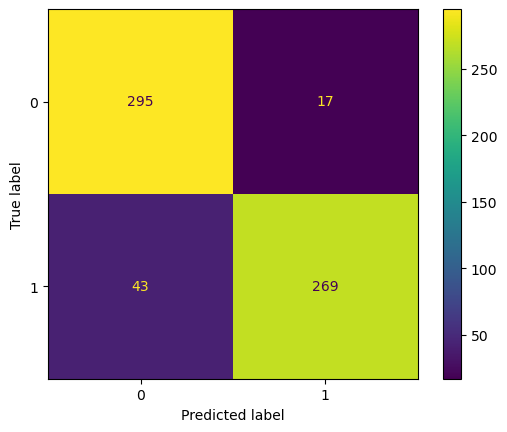

In [255]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(val_labels_true, val_preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.show()


## Plot AUC-ROC curve

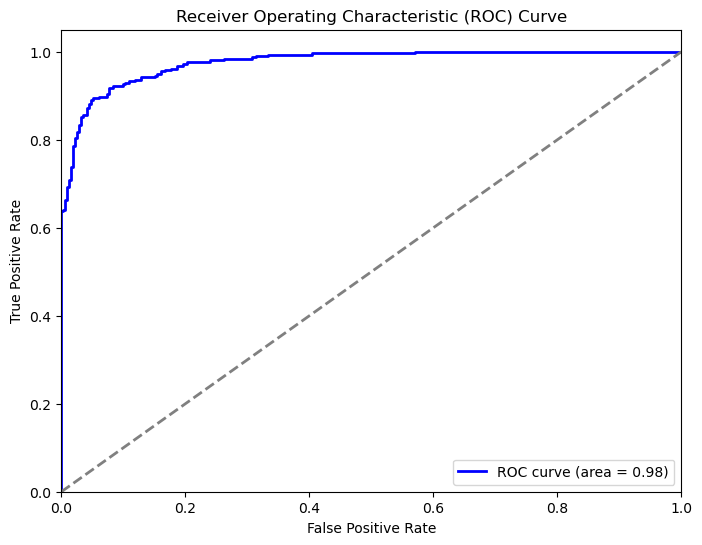

In [257]:


fpr, tpr, _ = roc_curve(val_labels_true, val_preds_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()